# initialization

In [125]:
from google.colab import drive
drive.mount('/content/gdrive')

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [126]:
downloaded = drive.CreateFile({'id':'1vkXUOP4lGvCaARhFOirBgj1VwmkX0VI-'}) # replace the id with id of file you want to access
downloaded.GetContentFile('cleaning_1.xlsx') 

In [127]:
downloaded = drive.CreateFile({'id':'1uWVz1y4tu3UTi7UXAEM1D4cy2KJpdUw8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('stop_words.txt') 

# preprocessing

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

df = pd.read_excel (r'cleaning_1.xlsx')
df.shape

df['intent'].replace(to_replace=[' drug+dose','drug+dose', 'drug+dpse'], value='drugs', inplace=True)
df['intent'].replace(to_replace=['contageos', 'contagious'] ,value ='contageous', inplace=True)
df['intent'].replace(to_replace=['info', 'Info'], value='information', inplace=True)


indexNames=df[(df['intent'] =='drugs') 
              | (df['intent'] =='food+product') 
              | (df['intent']=='vaccine')
              |(df['intent'] =='symptoms')].index.tolist()


df=df.iloc[indexNames,:]
df.intent.unique() , df.shape             

(array(['drugs', 'food+product', 'symptoms', 'vaccine'], dtype=object),
 (1984, 3))

# ABUBAKR CLEANING

In [129]:
# ==== Helper Methods =====
import re
import numpy as np
from nltk import ngrams
import matplotlib.pyplot as plt

# Clean/Normalize Arabic Text
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']
    
    #remove tashkeel
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    
    #remove longation
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
    
    #trim    
    text = text.strip()

    return text

In [130]:
#abubakr clean_str
df['question'] =  df['question'].apply(lambda x: clean_str(x))

# STOPWORDS

In [131]:
!pip install nltk
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords_list = stopwords.words('arabic')
#print(stopwords_list)
#---------------------------------------------------------------------------
egyp=[]
# Using readlines()

file1 = open("stop_words.txt", "r" ,encoding = "utf-8")
Lines = file1.readlines()
count = 0
# Strips the newline character
for line in Lines:
    count += 1
    egyp.append(line.strip())
    
    #print( line.strip())
#print(egyp)
#----------------------------------------------------------------------------
# combine two lists
egyp=egyp+stopwords_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
df['question']=df['question'].apply(lambda words: ' '.join(re.sub('^(ال)',"",word)
                                                           for word in words.split() if ((word not in egyp))))

# TRANSFORMER LIBR

In [133]:
!pip install transformers

In [134]:
import transformers
from transformers import AutoModel, BertTokenizerFast

In [135]:
from transformers import AutoTokenizer, AutoModel

# Mini:   asafaya/bert-mini-arabic
# Medium: asafaya/bert-medium-arabic
# Base:   asafaya/bert-base-arabic
# Large:  asafaya/bert-large-arabic



# training 

**THE MULTI CLASS -------------------------------------------------------------**



In [136]:
#encoding the intents
possible_labels = df.intent.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'drugs': 0, 'food+product': 1, 'symptoms': 2, 'vaccine': 3}

In [137]:
df['label'] = df.intent.replace(label_dict)

In [138]:
#tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

#bert = AutoModel.from_pretrained("asafaya/bert-base-arabic")



# import BERT-base pretrained model
#bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [139]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [140]:
max_seq_len = 24

In [141]:
seq_len = 24
num_samples = len(df)

# initialize empty zero arrays
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# check shape
Xids.shape

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")


#tokenizer = BertTokenizer.from_pretrained("aubmindlab/bert-base-arabert")

for i, phrase in enumerate(df['question']):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    # assign tokenized outputs to respective rows in numpy arrays
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [142]:
import tensorflow as tf
import tensorflow 

from tensorflow import keras
from keras.layers import Dense

In [143]:
# first extract sentiment column
arr = df['label'].values

# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))

# set relevant index for each row to 1 (one-hot encode)
labels[np.arange(num_samples), arr] = 1

In [144]:
# create the dataset object
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

In [145]:
# we will split into batches of 16
batch_size = 16

# shuffle and batch - dropping any remaining samples that don't cleanly
# fit into a batch of 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

# split test and train

In [146]:
# set split size (90% training data) and calculate training set size
split = 0.7
size = int((Xids.shape[0]/batch_size)*split)

# get training and validation sets
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [147]:
# AutoModel for PyTorch, TFAutoModel for TensorFlow
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained("asafaya/bert-base-arabic")

#bert = TFAutoModel.from_pretrained("aubmindlab/bert-base-arabert")



Some layers from the model checkpoint at asafaya/bert-base-arabic were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at asafaya/bert-base-arabic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [148]:
# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(24,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(24,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access pooled activations with [1]

# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(4, activation='softmax', name='outputs')(x)

In [149]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
#model.layers[2].trainable = False

In [150]:

optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [151]:
#history = model.fit(
 #   train_ds,
 #   epochs=3
#)

In [152]:
#loss, accuracy = model.evaluate(val_ds)

# documentation

In [153]:

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub



import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)

model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
#model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

history =model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


86/86 [==============================] - 470s 5s/step - loss: 0.4348 - binary_accuracy: 0.8109 - val_loss: 0.3183 - val_binary_accuracy: 0.8692
Epoch 2/15
86/86 [==============================] - 461s 5s/step - loss: 0.2873 - binary_accuracy: 0.8864 - val_loss: 0.2121 - val_binary_accuracy: 0.9219
Epoch 3/15
86/86 [==============================] - 459s 5s/step - loss: 0.2213 - binary_accuracy: 0.9157 - val_loss: 0.1470 - val_binary_accuracy: 0.9519
Epoch 4/15
86/86 [==============================] - 460s 5s/step - loss: 0.1694 - binary_accuracy: 0.9400 - val_loss: 0.1097 - val_binary_accuracy: 0.9659
Epoch 5/15
86/86 [==============================] - 461s 5s/step - loss: 0.1308 - binary_accuracy: 0.9571 - val_loss: 0.0779 - val_binary_accuracy: 0.9786
Epoch 6/15
86/86 [==============================] - 453s 5s/step - loss: 0.1014 - binary_accuracy: 0.9648 - val_loss: 0.0486 - val_binary_accuracy: 0.9877
Epoch 7/15
86/86 [==============================] - 465s 5s/step - loss: 0.0702 -

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])




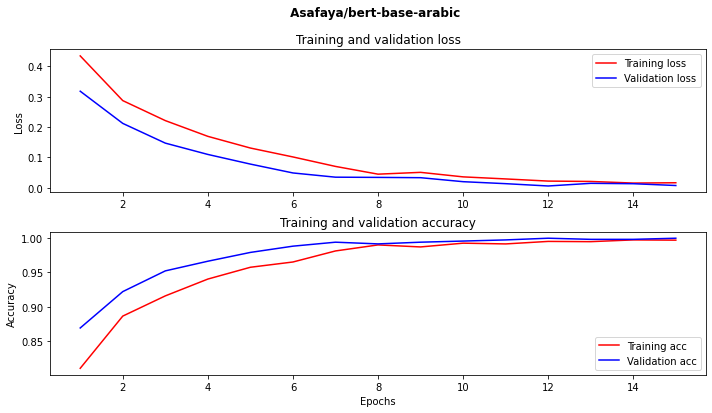

In [154]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

st = fig.suptitle('         Asafaya/bert-base-arabic\n \n' ,weight="bold")


plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print("\n")

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.tight_layout()



# shift subplots down:
st.set_y(0.95)
plt.subplots_adjust(top=0.85)

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])




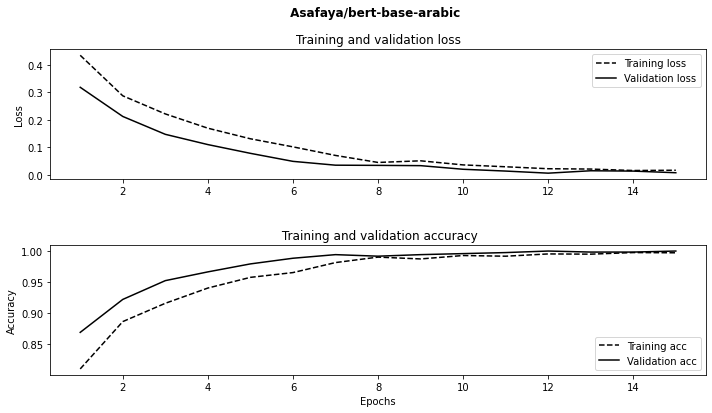

In [155]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()


st = fig.suptitle('         Asafaya/bert-base-arabic\n \n' ,weight="bold")

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'black',linestyle='dashed', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'black',label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
print("\n")


plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'black',linestyle='dashed', label='Training acc')
plt.plot(epochs, val_acc, 'black', label='Validation acc')
plt.title('\n \n Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')



import matplotlib.pyplot as plt


plt.tight_layout() # Or equivalently,  "plt.tight_layout()"

#plt.show()


# shift subplots down:
st.set_y(0.95)
plt.subplots_adjust(top=0.85)

# saving model

In [ ]:
# save model files to directory '/sentiment_model'
directory='/content/gdrive/My Drive/kera22.model'
model.save(directory)

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/kera22.model')

input preparing

In [ ]:
# initialize tokenizer from transformers
tokenizer = BertTokenizer.from_pretrained("asafaya/bert-base-arabic")

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizer.encode_plus(text, max_length=25,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
in_tensor = prep_data("ما هي التطعيمات الذي يجب ان ياخذها طفل فيي سن السنه و النصف")

probs = model.predict(in_tensor)[0]

probs

In [ ]:
import numpy as np

np.argmax(probs)

In [ ]:
#np.argmin(probs)

In [ ]:
#dff.question[2000]

In [ ]:
#dff.label[2000]

In [ ]:
pred= np.argmax(probs)
#pred=4
if pred==0:
  print('Drugs')
elif pred==1:
  print('food+product')
elif pred==2:
  print('symptoms')
elif pred==3:
  print('test')
elif pred==4:
  print('vaccine')    

#{'drugs': 0, 'food+product': 1, 'symptoms': 2, 'test': 3, 'vaccine': 4}